In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import scipy.cluster.hierarchy as hac
from scipy.cluster.hierarchy import dendrogram

from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import fcluster


In [3]:
import requests

POLONIEX_OHLCV_BASEURL = 'https://poloniex.com/public?command=returnChartData&currencyPair='

"""
https://poloniex.com/public?command=returnChartData&currencyPair=BTC_POT&start=1435699200&end=9999999999&period=14400

"""

def get_ohlcv_poloniex(pair='BTC_ETH', start=1435699200, end=9999999999, period=900):
    """
    returns ohlcv data for poloniex as pandas dataframe
    convert to unix timestamp using https://coderstoolbox.net/unixtimestamp/
    :param pair: str pair on poloniex
    :param start: int unix timestamp of beginning time
    :param end: int unix timestamp of ending time
    :param period: int candle width in seconds
    :return: pandas df of ohlcv data from poloniex for specified pair, times, and period
    """
    query = POLONIEX_OHLCV_BASEURL + pair + '&start=' + str(start) + '&end=' + str(end) + '&period=' + str(period)
    resp = requests.get(query)

    if resp.status_code != 200:
        raise requests.ApiError('GET /tasks/ {}'.format(resp.status_code))

    return pd.DataFrame(resp.json())

In [4]:
def fancy_dendrogram(*args, **kwargs):
    plt.figure(figsize=(10,8))
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [5]:
def generate_clusters(timeSeries, pair):
    z_euclidean = hac.linkage(timeSeries, method='single', metric='euclidean')
    z_minkowski = hac.linkage(timeSeries, method='single', metric='minkowski')
    z_cityblock = hac.linkage(timeSeries, method='single', metric='cityblock')
    z_cosine = hac.linkage(timeSeries, method='single', metric='cosine')
    autoCorrSeries = timeSeries.copy()
    lag = 5
    autoCorrSeries['lagged'] = autoCorrSeries[pair].shift(lag)
    autoCorrSeries = autoCorrSeries.iloc[lag:]
    z_correlation = hac.linkage(autoCorrSeries, method='single', metric='correlation')

    p = 12
    max_d = .01  # max_d as in max_distance
    print("Euclidean")
    fancy_dendrogram(
        z_euclidean,
        truncate_mode='lastp',
        p=p,
        leaf_rotation=90.,
        leaf_font_size=12.,
        show_contracted=True,
        annotate_above=10,  # useful in small plots so annotations don't overlap
        max_d=max_d,
    )
    plt.show()

    print("Minkowski")
    fancy_dendrogram(
        z_minkowski,
        truncate_mode='lastp',
        p=p,
        leaf_rotation=90.,
        leaf_font_size=12.,
        show_contracted=True,
        annotate_above=10,  # useful in small plots so annotations don't overlap
        max_d=max_d,
    )
    plt.show()

    print("Cityblock")
    fancy_dendrogram(
        z_cityblock,
        truncate_mode='lastp',
        p=p,
        leaf_rotation=90.,
        leaf_font_size=12.,
        show_contracted=True,
        annotate_above=10,  # useful in small plots so annotations don't overlap
        max_d=max_d,
    )
    plt.show()

    print("Cosine")
    fancy_dendrogram(
        z_cosine,
        truncate_mode='lastp',
        p=p,
        leaf_rotation=90.,
        leaf_font_size=12.,
        show_contracted=True,
        annotate_above=10,  # useful in small plots so annotations don't overlap
        max_d=max_d,
    )
    plt.show()

    print("Correlation")
    fancy_dendrogram(
        z_correlation,
        truncate_mode='lastp',
        p=p,
        leaf_rotation=90.,
        leaf_font_size=12.,
        show_contracted=True,
        annotate_above=10,  # useful in small plots so annotations don't overlap
    )
    plt.show()

    c, coph_dists = cophenet(z_euclidean, pdist(timeSeries))
    print("Euclidean Cophenetic Correlation Coefficient: " + str(c))
    c, coph_dists = cophenet(z_minkowski, pdist(timeSeries))
    print("Minkowski Cophenetic Correlation Coefficient: " + str(c))
    c, coph_dists = cophenet(z_cityblock, pdist(timeSeries))
    print("Cityblock Cophenetic Correlation Coefficient: " + str(c))
    c, coph_dists = cophenet(z_cosine, pdist(timeSeries))
    print("Cosine Cophenetic Correlation Coefficient: " + str(c))
    c, coph_dists = cophenet(z_correlation, pdist(autoCorrSeries))
    print("Correlation Cophenetic Correlation Coefficient: " + str(c))
    
    print("Euclidean Clusters")
    clusters = fcluster(z_euclidean, max_d, criterion='distance')
    plt.figure(figsize=(10, 8))
    plt.scatter(timeSeries[pair], timeSeries[pair], c=clusters, cmap='prism')  # plot points with cluster dependent colors
    plt.show()
    
    print("Minkowski Clusters")
    clusters = fcluster(z_minkowski, max_d, criterion='distance')
    plt.figure(figsize=(10, 8))
    plt.scatter(timeSeries[pair], timeSeries[pair], c=clusters, cmap='prism')  # plot points with cluster dependent colors
    plt.show()
        
    print("Cityblock Clusters")
    clusters = fcluster(z_cityblock, max_d, criterion='distance')
    plt.figure(figsize=(10, 8))
    plt.scatter(timeSeries[pair], timeSeries[pair], c=clusters, cmap='prism')  # plot points with cluster dependent colors
    plt.show()
    
    print("Cosine Clusters")
    clusters = fcluster(z_cosine, max_d, criterion='distance')
    plt.figure(figsize=(10, 8))
    plt.scatter(timeSeries[pair], timeSeries[pair], c=clusters, cmap='prism')  # plot points with cluster dependent colors
    plt.show()
    
    print("Correlation Clusters")
    clusters = fcluster(z_correlation, max_d, criterion='distance')
    plt.figure(figsize=(10, 8))
    plt.scatter(autoCorrSeries[pair], autoCorrSeries["lagged"], c=clusters, cmap='prism')  # plot points with cluster dependent colors
    plt.show()

USDT_BTC
Euclidean


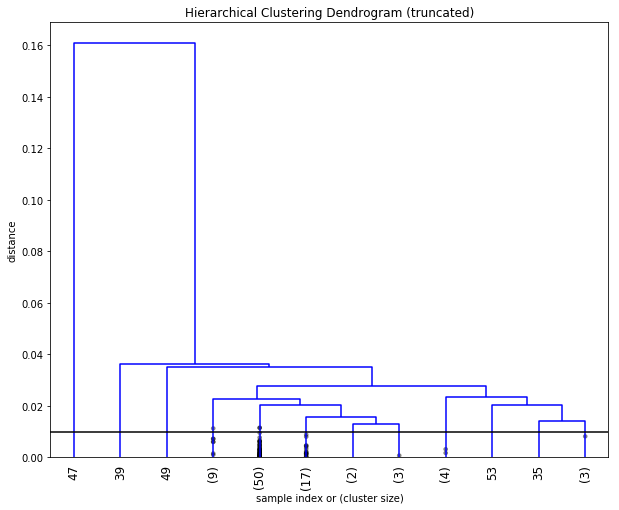

Minkowski


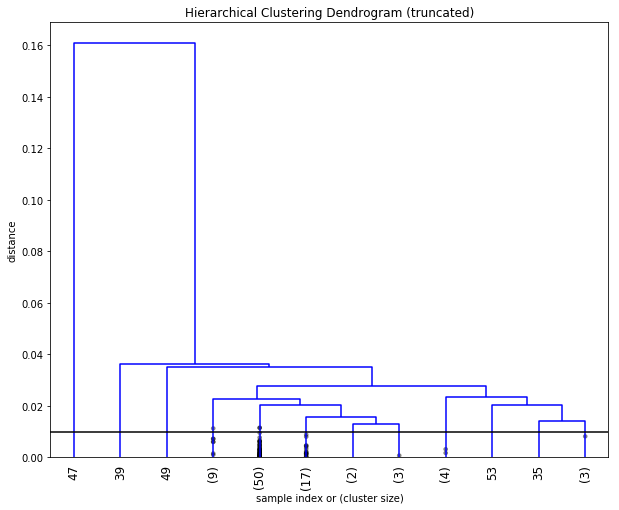

Cityblock


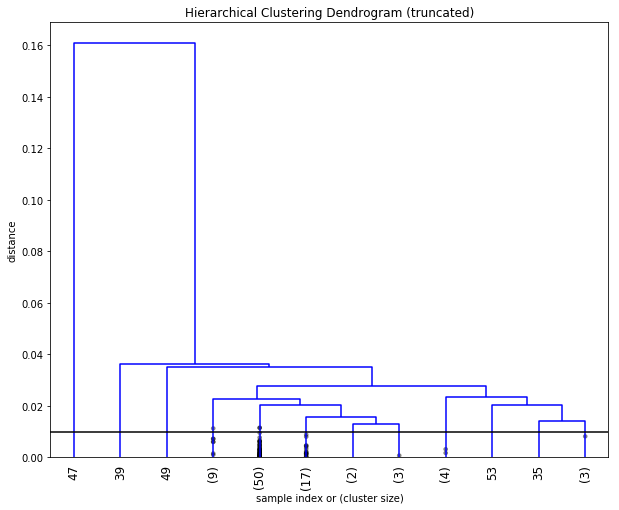

Cosine


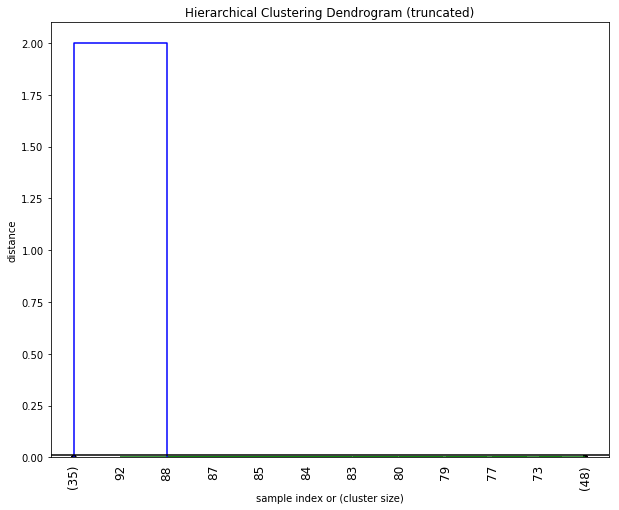

Correlation


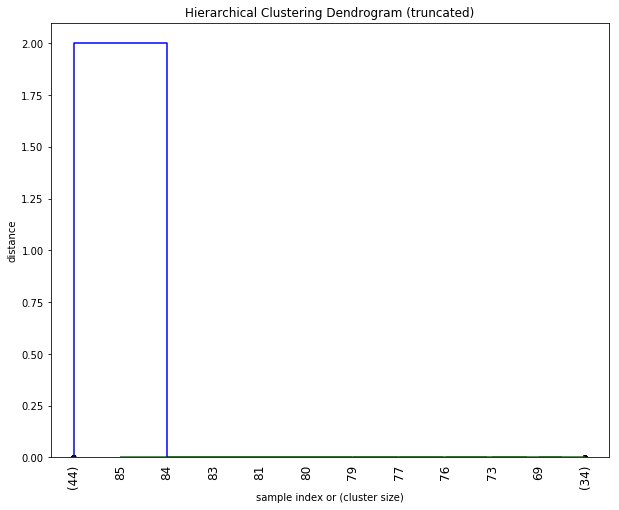

Euclidean Cophenetic Correlation Coefficient: 0.5878360923843923
Minkowski Cophenetic Correlation Coefficient: 0.5878360923843923
Cityblock Cophenetic Correlation Coefficient: 0.5878360923843923
Cosine Cophenetic Correlation Coefficient: 0.5603750169577935
Correlation Cophenetic Correlation Coefficient: 0.3335960602228012
Euclidean Clusters


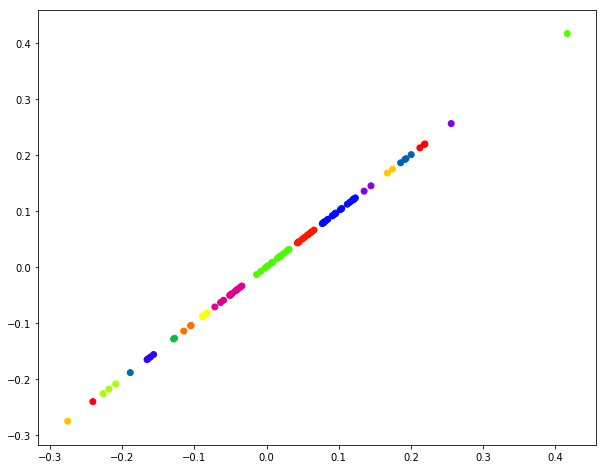

Minkowski Clusters


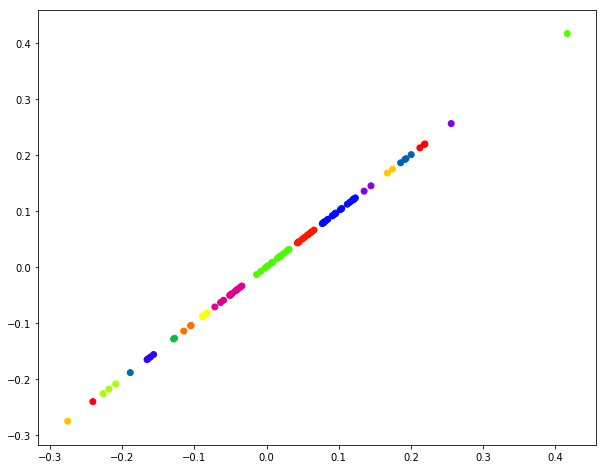

Cityblock Clusters


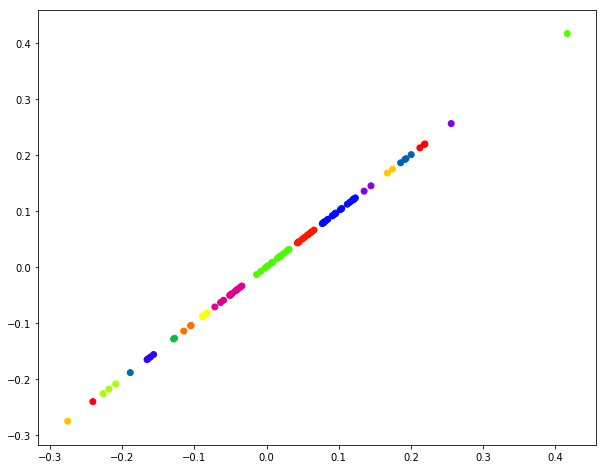

Cosine Clusters


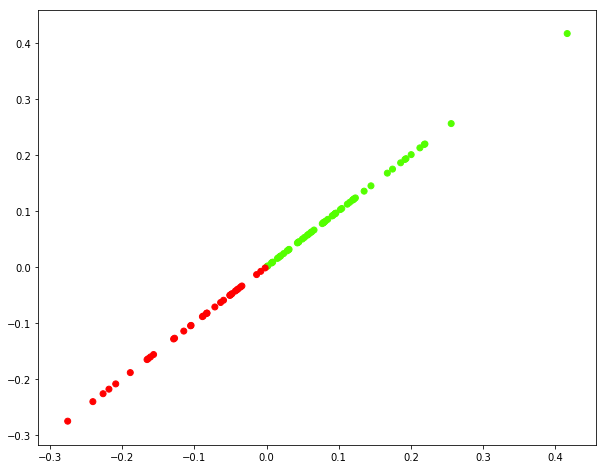

Correlation Clusters


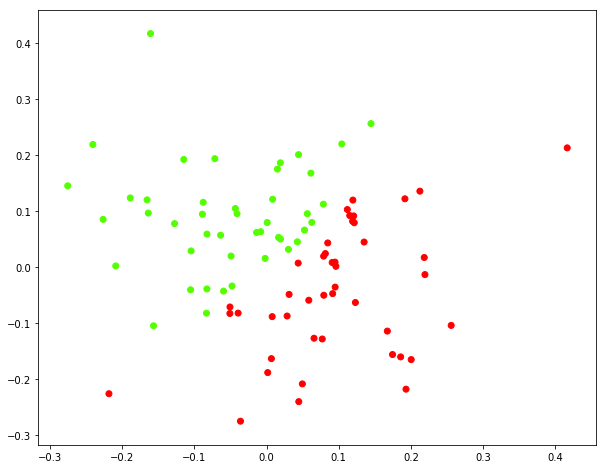

In [6]:
# timeSeries = get_ohlcv_poloniex(pair='USDT_BTC', start=1483600958, end=9999999999, period=86400)
# timeSeries = pd.DataFrame(timeSeries['weightedAverage'])
# timeSeries.name = 'USDT_BTC'
# df_USDT_ETH = get_ohlcv_poloniex(pair='USDT_ETH', start=1483600958, end=9999999999, period=86400)
# df_USDT_ETH = pd.DataFrame(df_USDT_ETH['weightedAverage'])
# df_USDT_ETH.name = 'USDT_ETH'
# pd.concat([timeSeries,df_USDT_ETH], axis=1)


#for pair in ['USDT_BTC','USDT_ETH', 'USDT_LTC', 'USDT_DASH', 'BTC_ETH', 'BTC_LTC', 'BTC_DASH']:
pair = 'USDT_BTC'
timeSeries = pd.DataFrame()
df = get_ohlcv_poloniex(pair=pair, start=1483600958, end=9999999999, period=86400)
df = df[df.index % 7 == 0]
df['pct_change'] = df['weightedAverage'].pct_change()
df['log_ret'] = np.log(df['weightedAverage']) - np.log(df['weightedAverage'].shift(1))
df[pair] = df['log_ret']
df = pd.DataFrame(df[pair])
timeSeries = pd.concat([timeSeries,df], axis=1)
timeSeries = timeSeries.iloc[1:]
print(pair)
generate_clusters(timeSeries, pair)


    


USDT_ETH
Euclidean


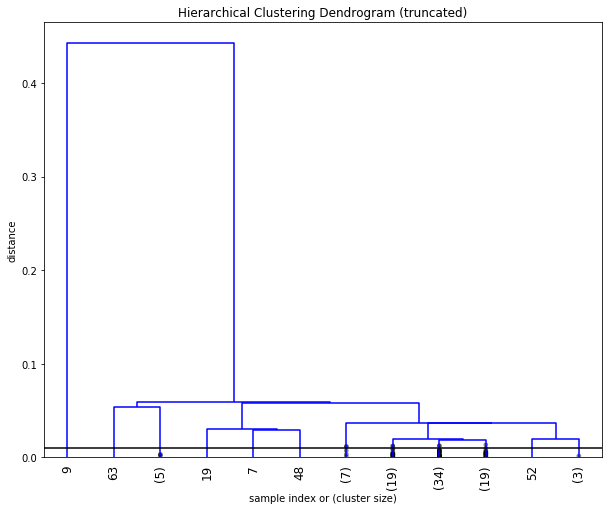

Minkowski


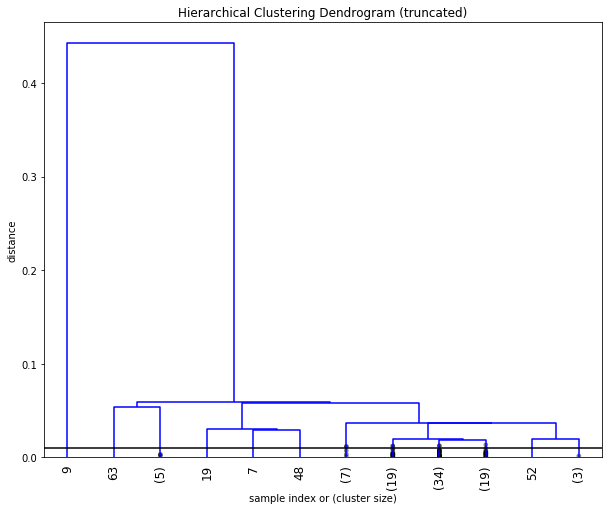

Cityblock


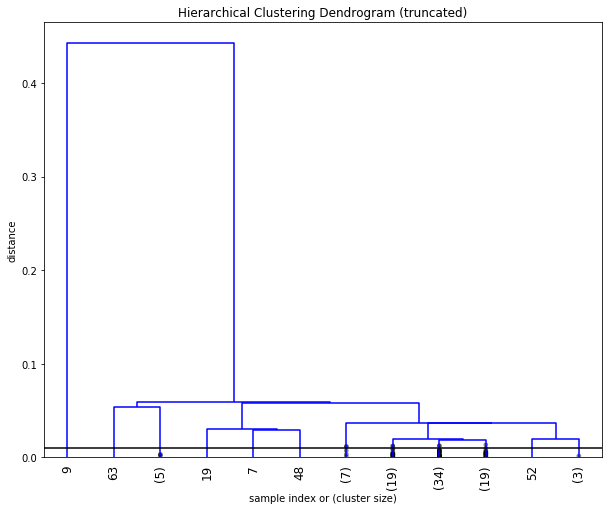

Cosine


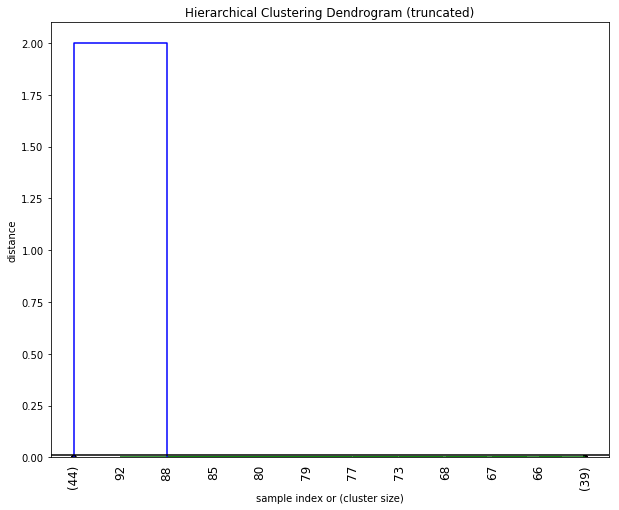

Correlation


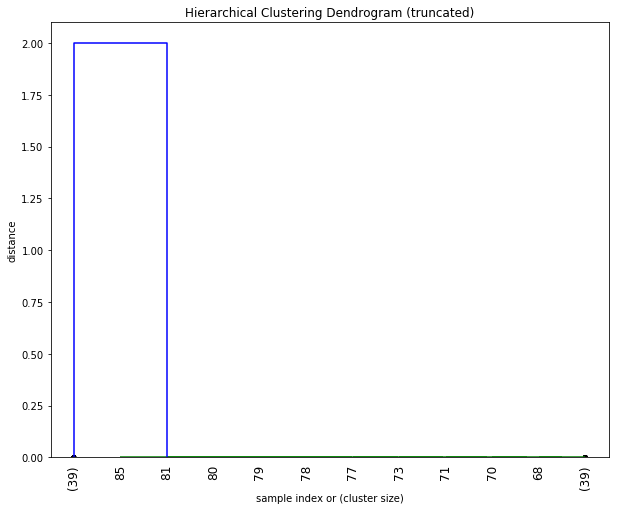

Euclidean Cophenetic Correlation Coefficient: 0.7117402747415241
Minkowski Cophenetic Correlation Coefficient: 0.7117402747415241
Cityblock Cophenetic Correlation Coefficient: 0.7117402747415241
Cosine Cophenetic Correlation Coefficient: 0.42530243500365356
Correlation Cophenetic Correlation Coefficient: 0.2918851565155661
Euclidean Clusters


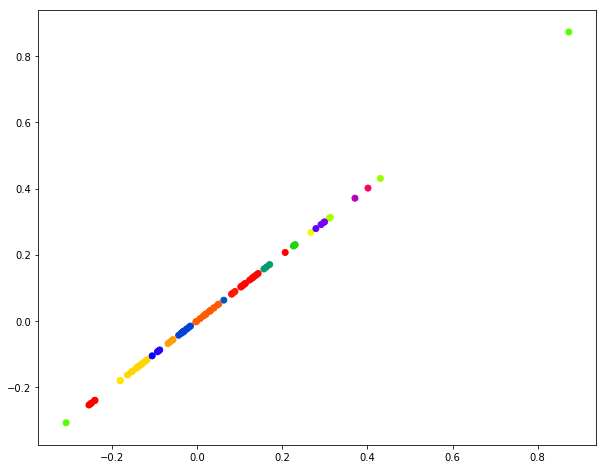

Minkowski Clusters


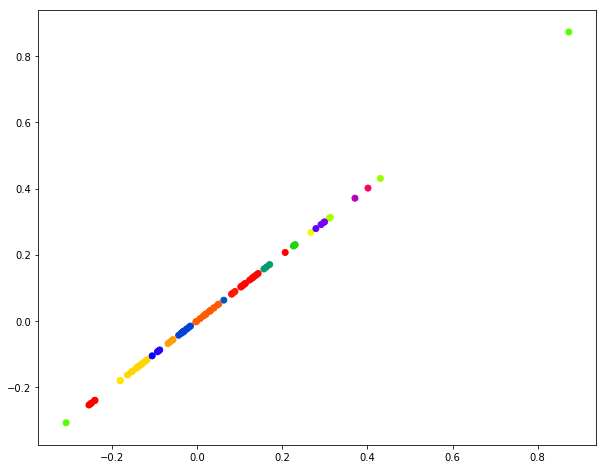

Cityblock Clusters


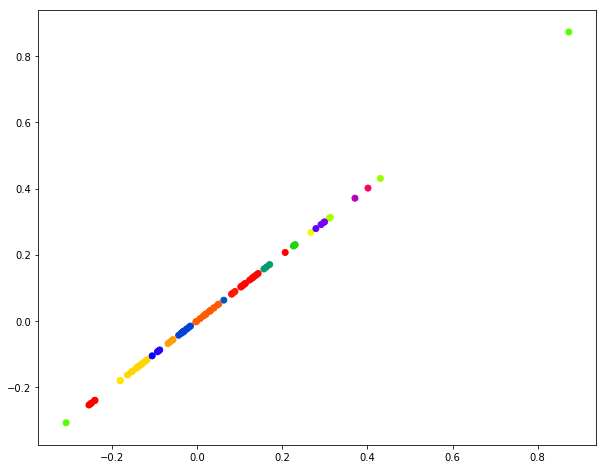

Cosine Clusters


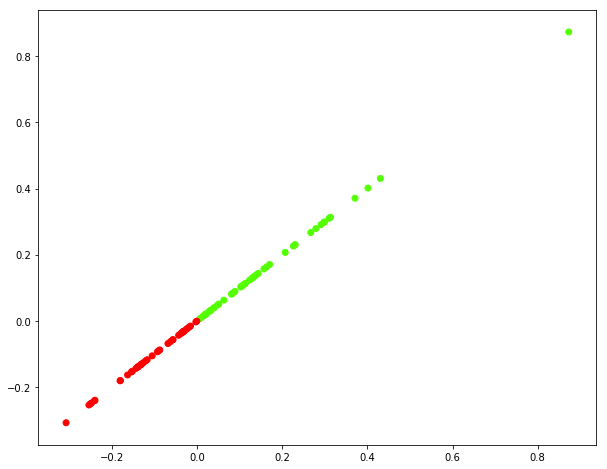

Correlation Clusters


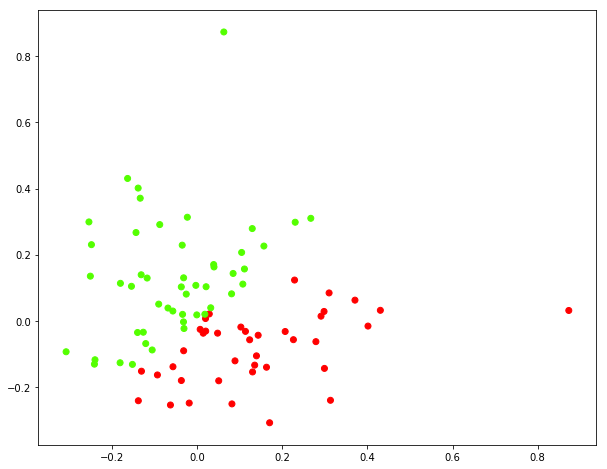

In [7]:
pair = 'USDT_ETH'
timeSeries = pd.DataFrame()
df = get_ohlcv_poloniex(pair=pair, start=1483600958, end=9999999999, period=86400)
df = df[df.index % 7 == 0]
df['pct_change'] = df['weightedAverage'].pct_change()
df['log_ret'] = np.log(df['weightedAverage']) - np.log(df['weightedAverage'].shift(1))
df[pair] = df['log_ret']
df = pd.DataFrame(df[pair])
timeSeries = pd.concat([timeSeries,df], axis=1)
timeSeries = timeSeries.iloc[1:]
print(pair)
generate_clusters(timeSeries, pair)

USDT_LTC
Euclidean


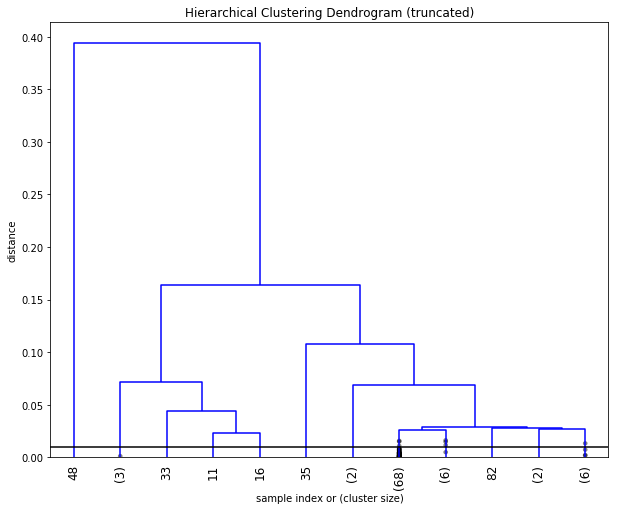

Minkowski


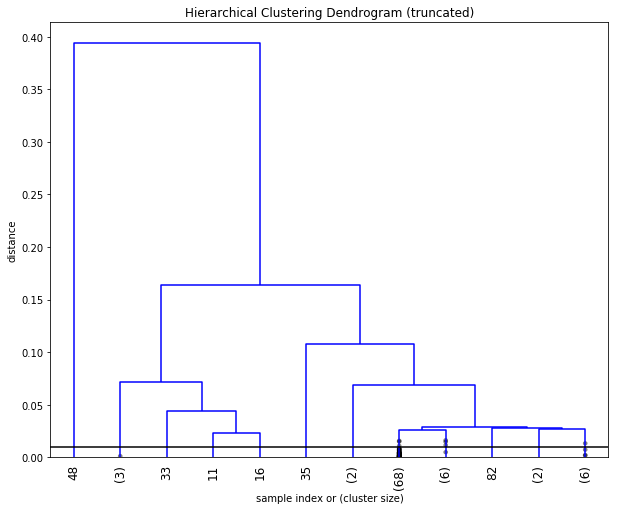

Cityblock


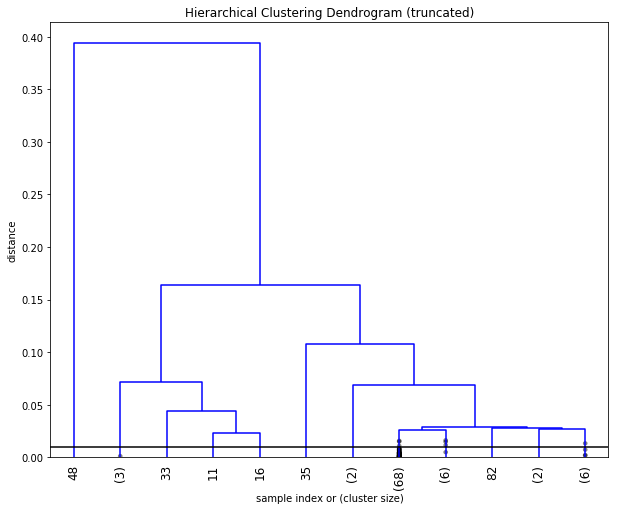

Cosine


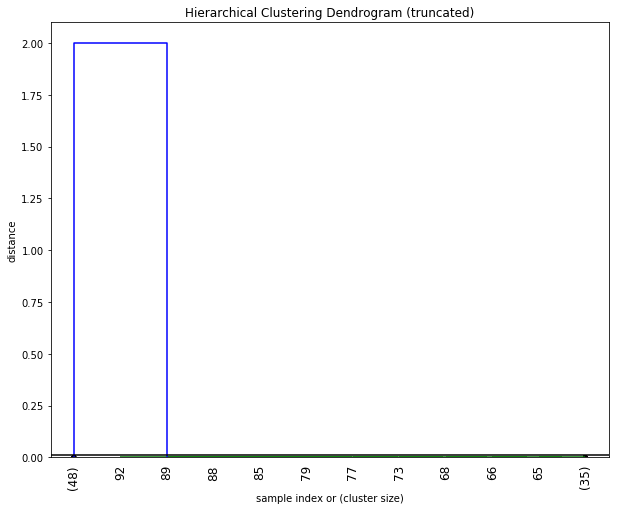

Correlation


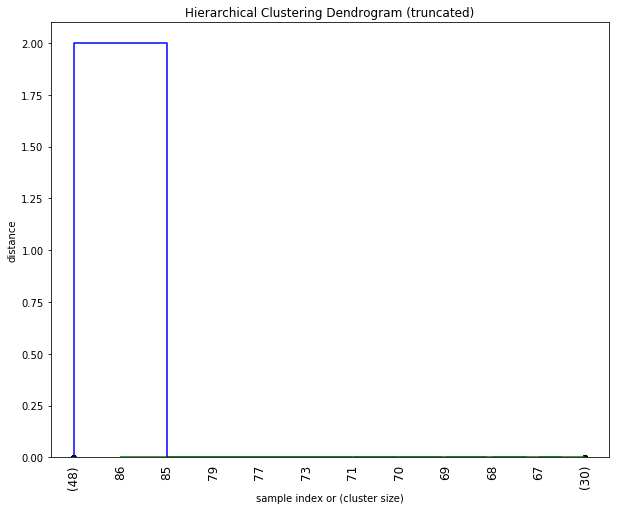

Euclidean Cophenetic Correlation Coefficient: 0.8785273817664351
Minkowski Cophenetic Correlation Coefficient: 0.8785273817664351
Cityblock Cophenetic Correlation Coefficient: 0.8785273817664351
Cosine Cophenetic Correlation Coefficient: 0.31719270756179413
Correlation Cophenetic Correlation Coefficient: 0.2179601914114372
Euclidean Clusters


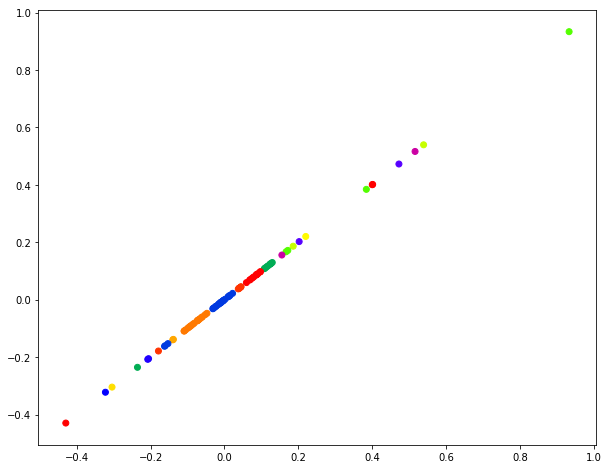

Minkowski Clusters


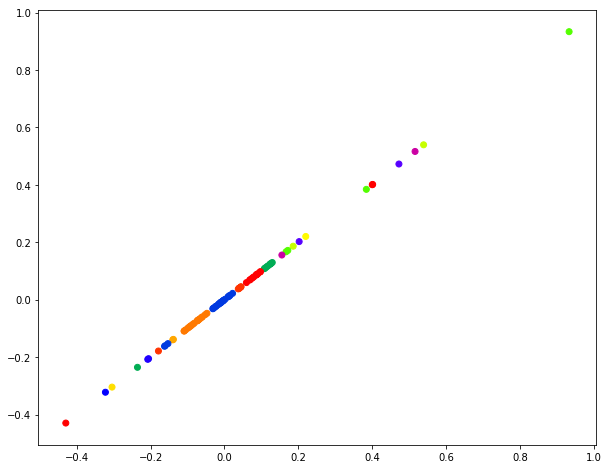

Cityblock Clusters


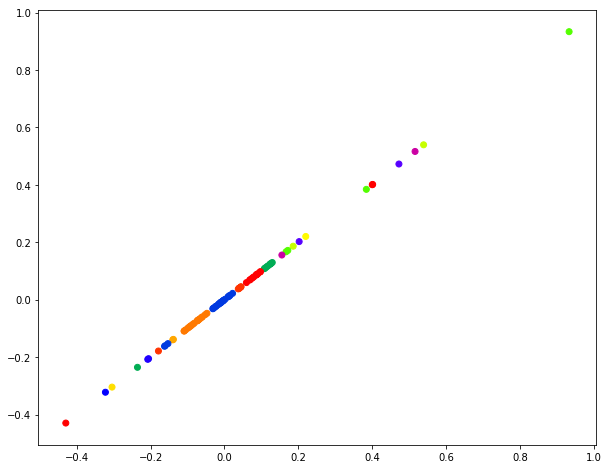

Cosine Clusters


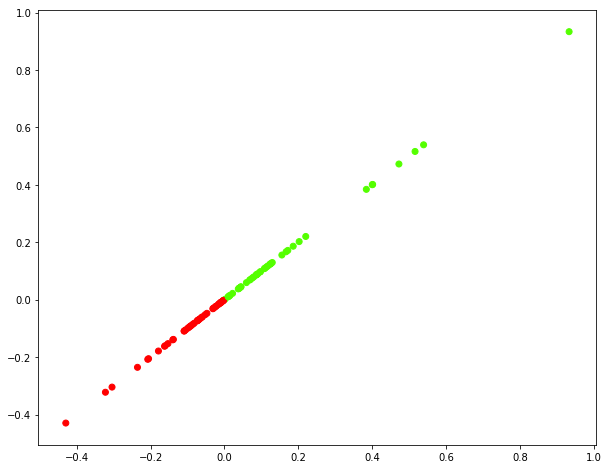

Correlation Clusters


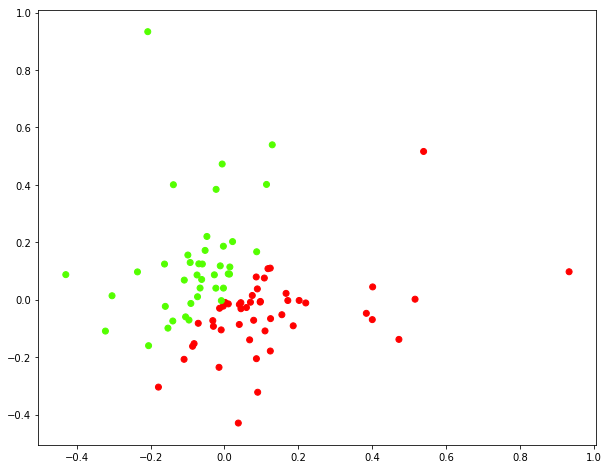

In [8]:
pair = 'USDT_LTC'
timeSeries = pd.DataFrame()
df = get_ohlcv_poloniex(pair=pair, start=1483600958, end=9999999999, period=86400)
df = df[df.index % 7 == 0]
df['pct_change'] = df['weightedAverage'].pct_change()
df['log_ret'] = np.log(df['weightedAverage']) - np.log(df['weightedAverage'].shift(1))
df[pair] = df['log_ret']
df = pd.DataFrame(df[pair])
timeSeries = pd.concat([timeSeries,df], axis=1)
timeSeries = timeSeries.iloc[1:]
print(pair)
generate_clusters(timeSeries, pair)

USDT_DASH
Euclidean


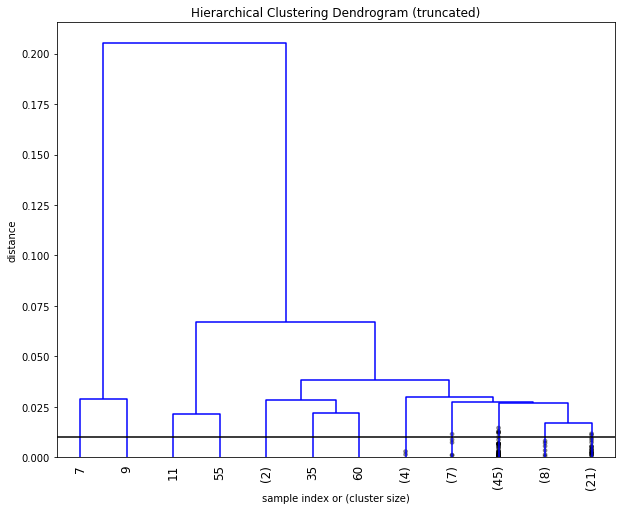

Minkowski


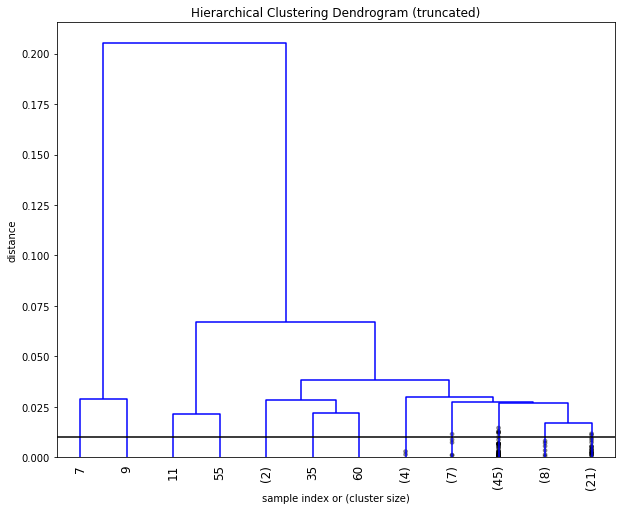

Cityblock


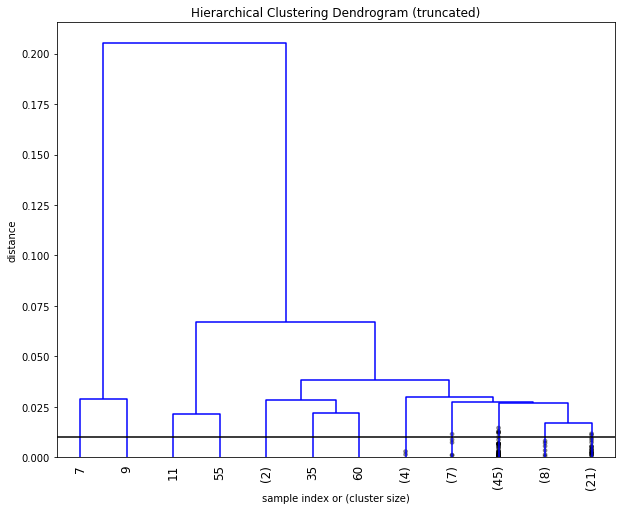

Cosine


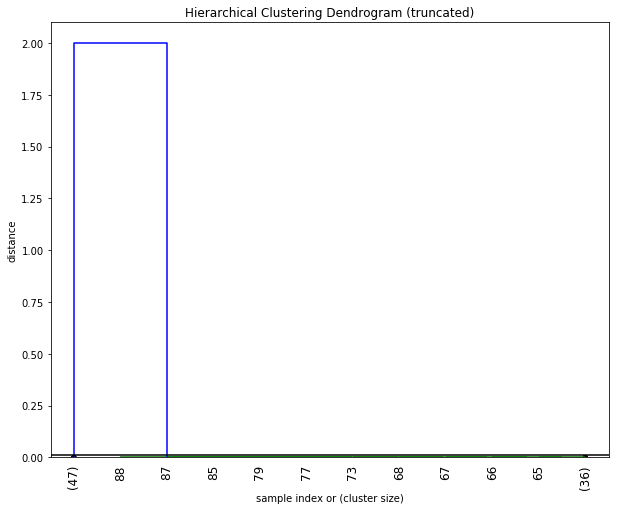

Correlation


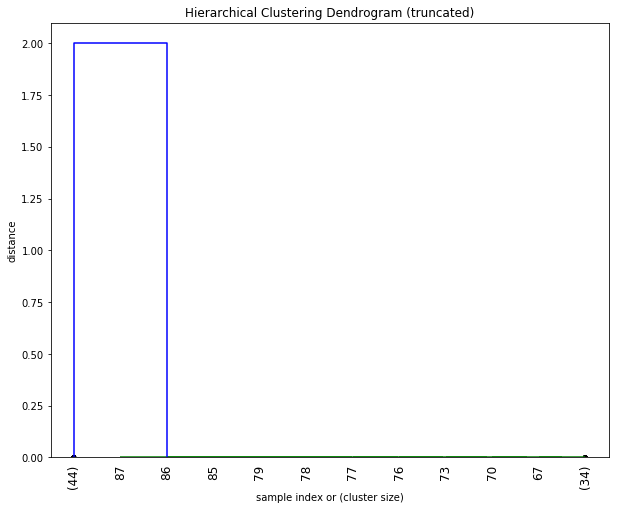

Euclidean Cophenetic Correlation Coefficient: 0.6389421770847296
Minkowski Cophenetic Correlation Coefficient: 0.6389421770847296
Cityblock Cophenetic Correlation Coefficient: 0.6389421770847296
Cosine Cophenetic Correlation Coefficient: 0.5320913446244276
Correlation Cophenetic Correlation Coefficient: 0.3324391207376678
Euclidean Clusters


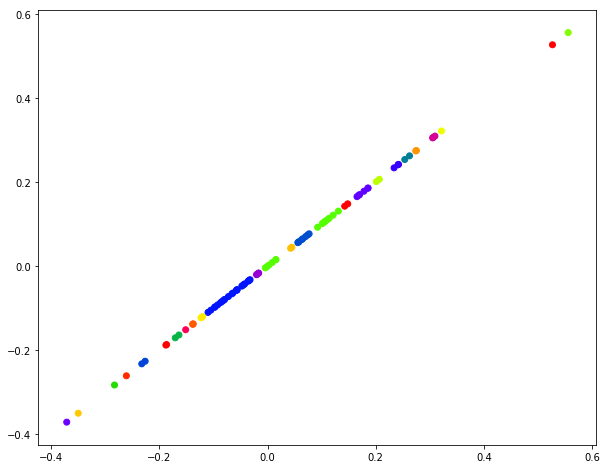

Minkowski Clusters


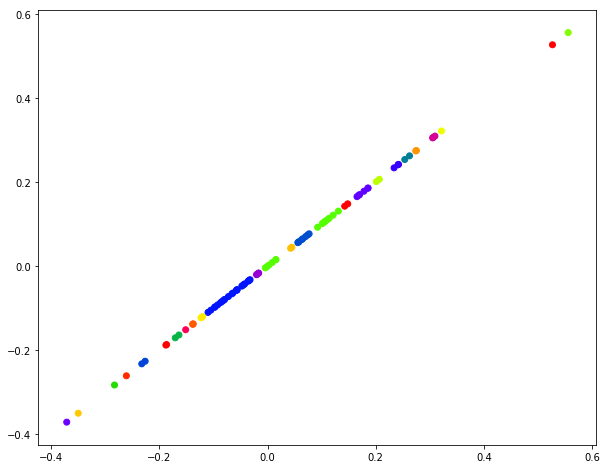

Cityblock Clusters


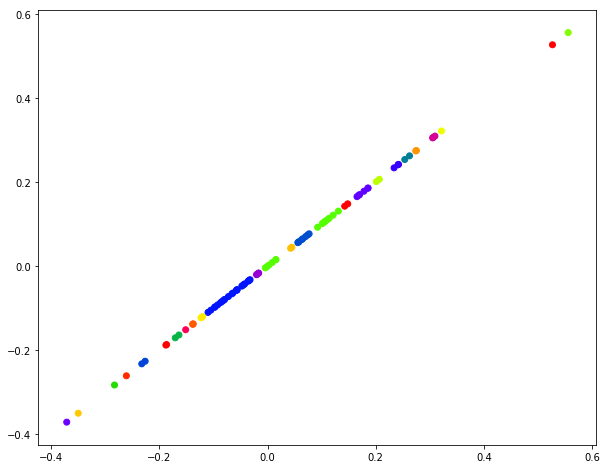

Cosine Clusters


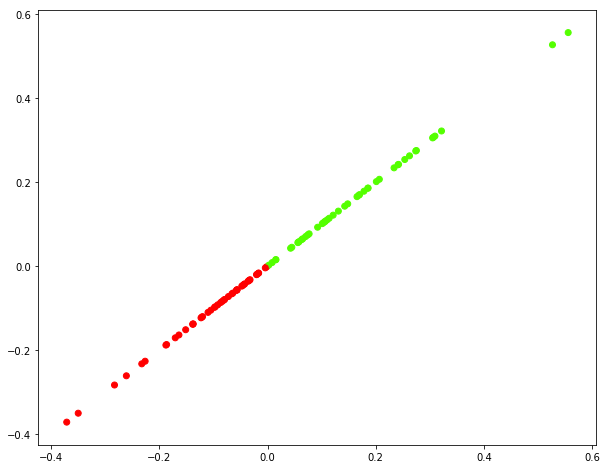

Correlation Clusters


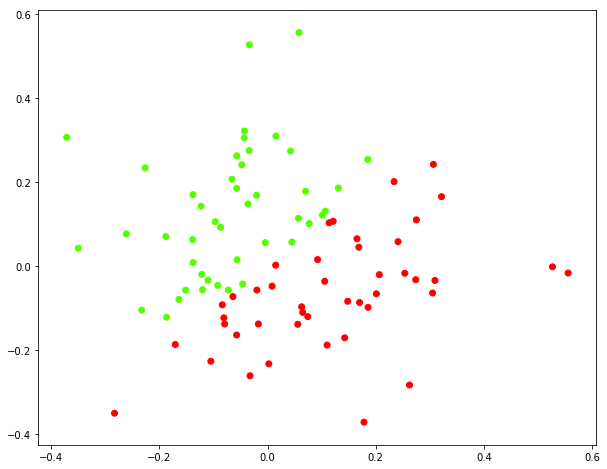

In [9]:
pair = 'USDT_DASH'
timeSeries = pd.DataFrame()
df = get_ohlcv_poloniex(pair=pair, start=1483600958, end=9999999999, period=86400)
df = df[df.index % 7 == 0]
df['pct_change'] = df['weightedAverage'].pct_change()
df['log_ret'] = np.log(df['weightedAverage']) - np.log(df['weightedAverage'].shift(1))
df[pair] = df['log_ret']
df = pd.DataFrame(df[pair])
timeSeries = pd.concat([timeSeries,df], axis=1)
timeSeries = timeSeries.iloc[1:]
print(pair)
generate_clusters(timeSeries, pair)

BTC_ETH
Euclidean


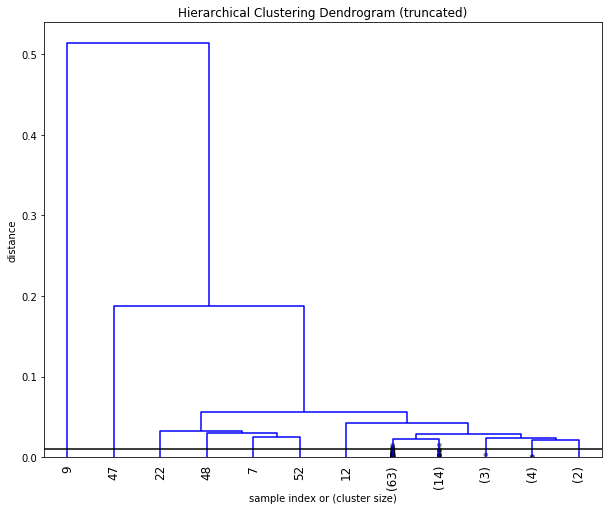

Minkowski


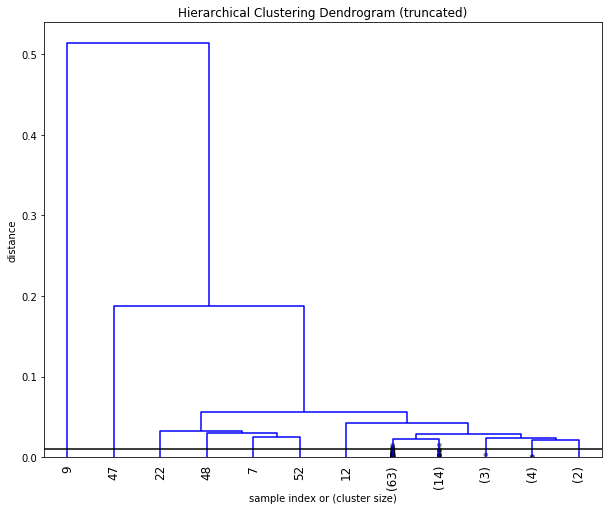

Cityblock


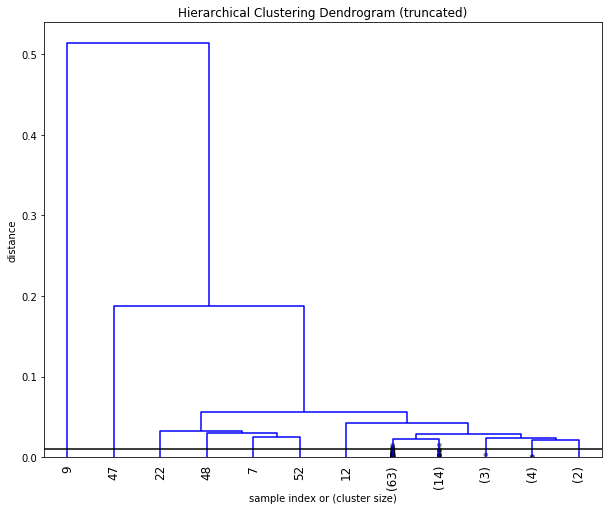

Cosine


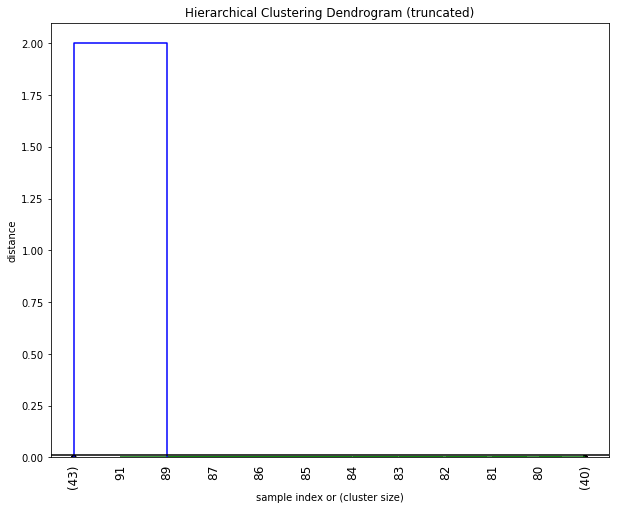

Correlation


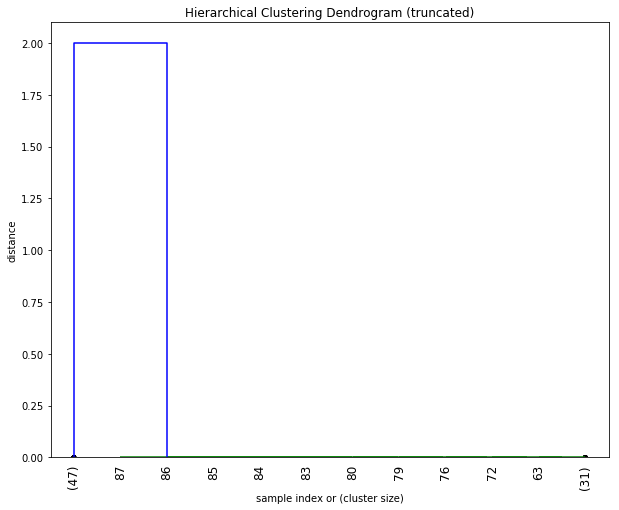

Euclidean Cophenetic Correlation Coefficient: 0.7823600890887809
Minkowski Cophenetic Correlation Coefficient: 0.7823600890887809
Cityblock Cophenetic Correlation Coefficient: 0.7823600890887809
Cosine Cophenetic Correlation Coefficient: 0.3628112438409152
Correlation Cophenetic Correlation Coefficient: 0.21398872220942936
Euclidean Clusters


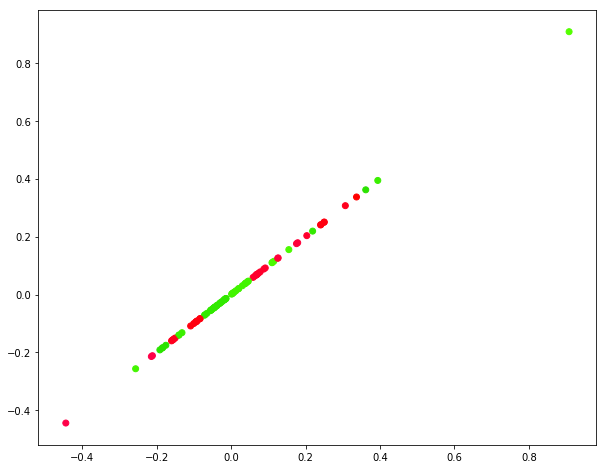

Minkowski Clusters


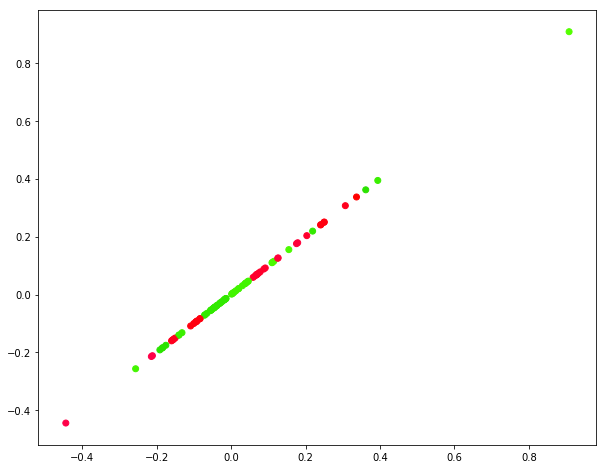

Cityblock Clusters


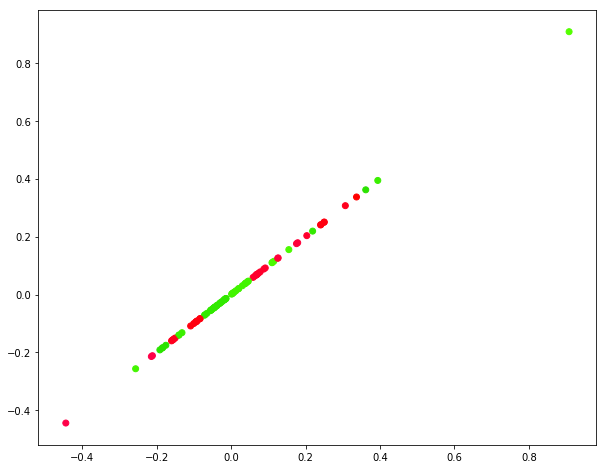

Cosine Clusters


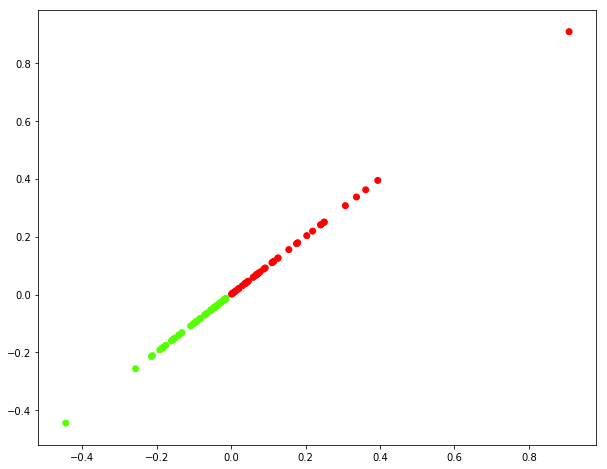

Correlation Clusters


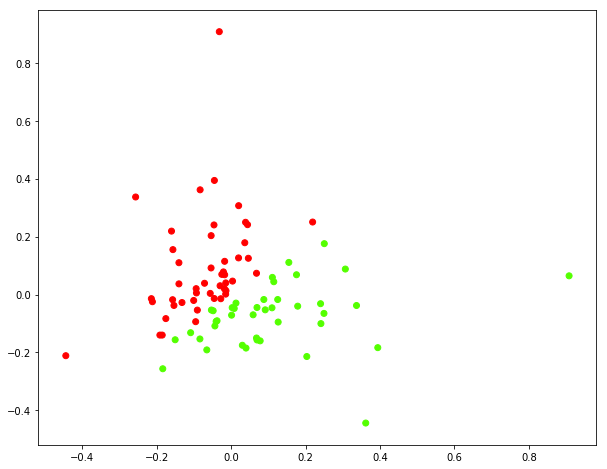

In [10]:
pair = 'BTC_ETH'
timeSeries = pd.DataFrame()
df = get_ohlcv_poloniex(pair=pair, start=1483600958, end=9999999999, period=86400)
df = df[df.index % 7 == 0]
df['pct_change'] = df['weightedAverage'].pct_change()
df['log_ret'] = np.log(df['weightedAverage']) - np.log(df['weightedAverage'].shift(1))
df[pair] = df['log_ret']
df = pd.DataFrame(df[pair])
timeSeries = pd.concat([timeSeries,df], axis=1)
timeSeries = timeSeries.iloc[1:]
print(pair)
generate_clusters(timeSeries, pair)

BTC_LTC
Euclidean


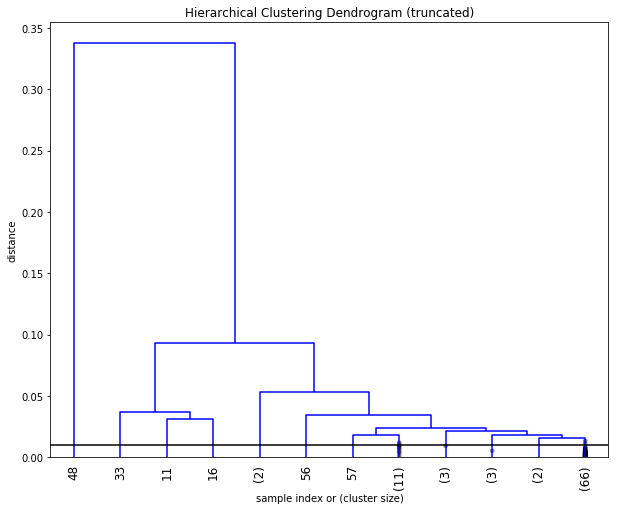

Minkowski


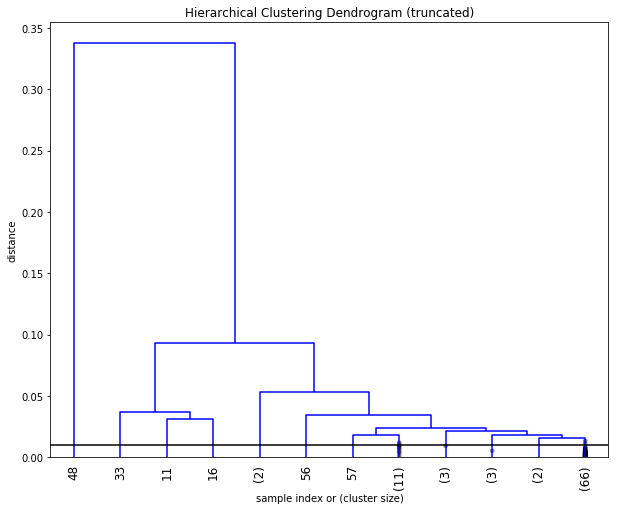

Cityblock


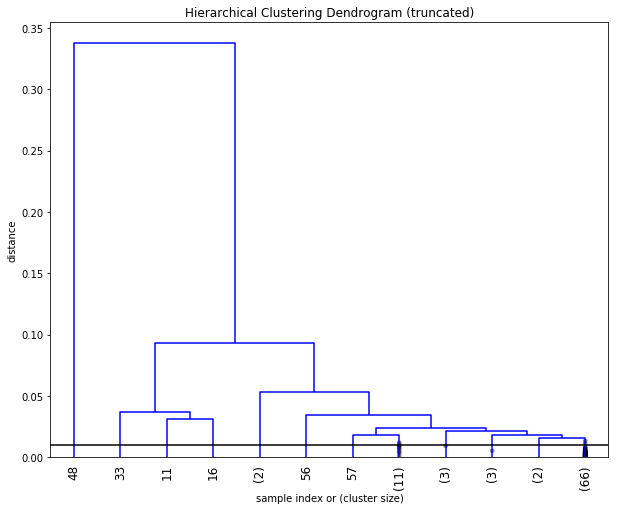

Cosine


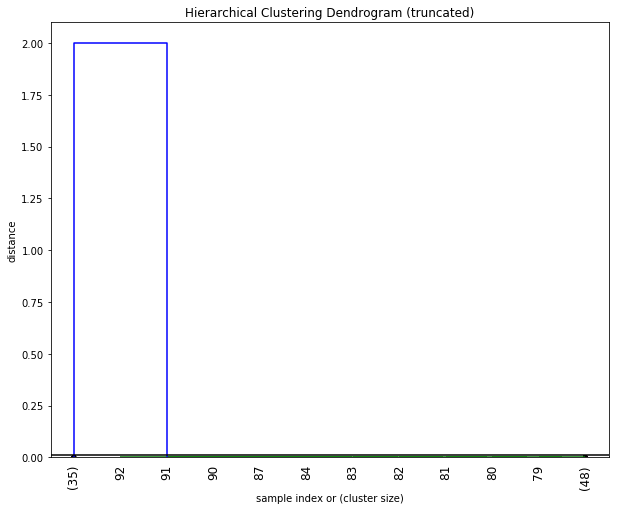

Correlation


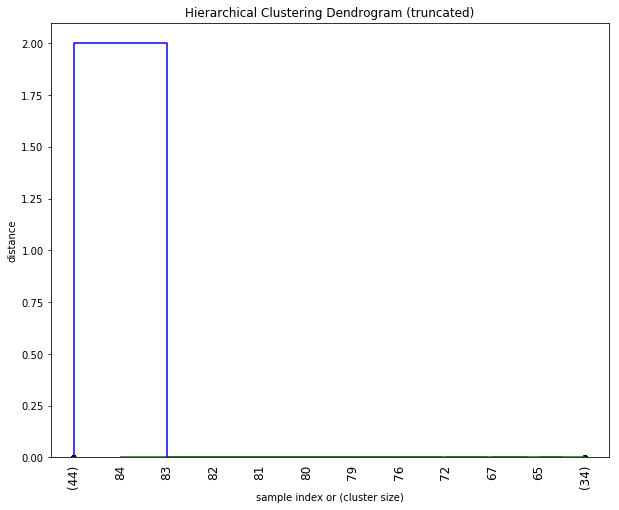

Euclidean Cophenetic Correlation Coefficient: 0.8432164594589984
Minkowski Cophenetic Correlation Coefficient: 0.8432164594589984
Cityblock Cophenetic Correlation Coefficient: 0.8432164594589984
Cosine Cophenetic Correlation Coefficient: 0.40371678070047773
Correlation Cophenetic Correlation Coefficient: 0.20130968858892087
Euclidean Clusters


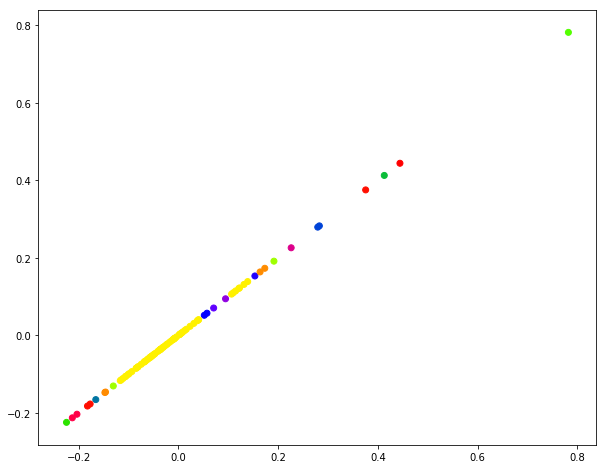

Minkowski Clusters


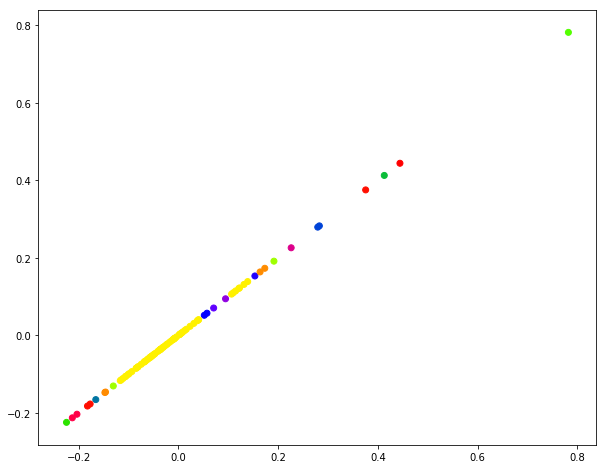

Cityblock Clusters


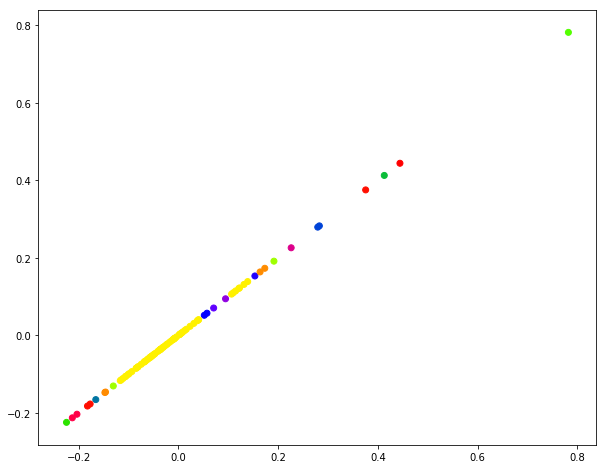

Cosine Clusters


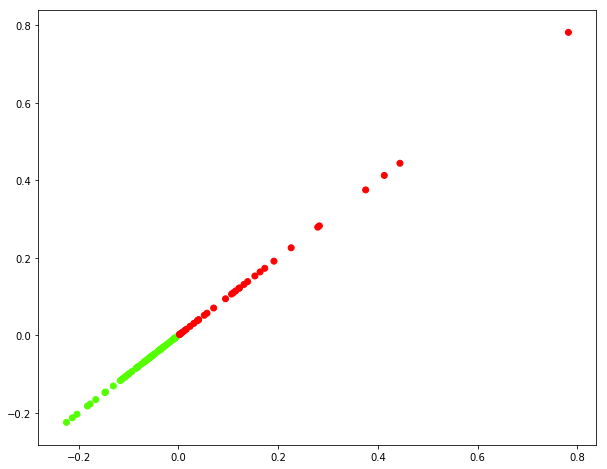

Correlation Clusters


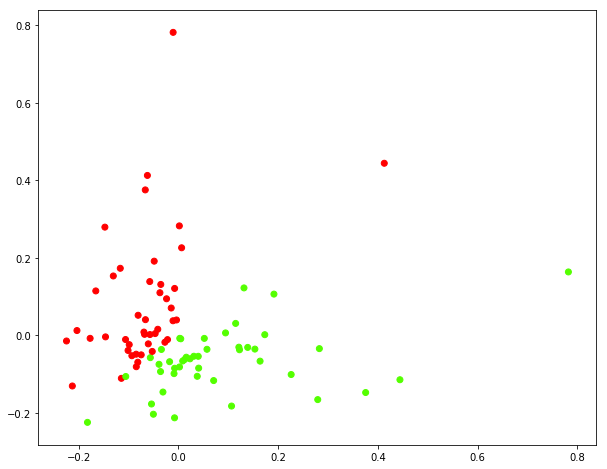

In [11]:
pair = 'BTC_LTC'
timeSeries = pd.DataFrame()
df = get_ohlcv_poloniex(pair=pair, start=1483600958, end=9999999999, period=86400)
df = df[df.index % 7 == 0]
df['pct_change'] = df['weightedAverage'].pct_change()
df['log_ret'] = np.log(df['weightedAverage']) - np.log(df['weightedAverage'].shift(1))
df[pair] = df['log_ret']
df = pd.DataFrame(df[pair])
timeSeries = pd.concat([timeSeries,df], axis=1)
timeSeries = timeSeries.iloc[1:]
print(pair)
generate_clusters(timeSeries, pair)

BTC_DASH
Euclidean


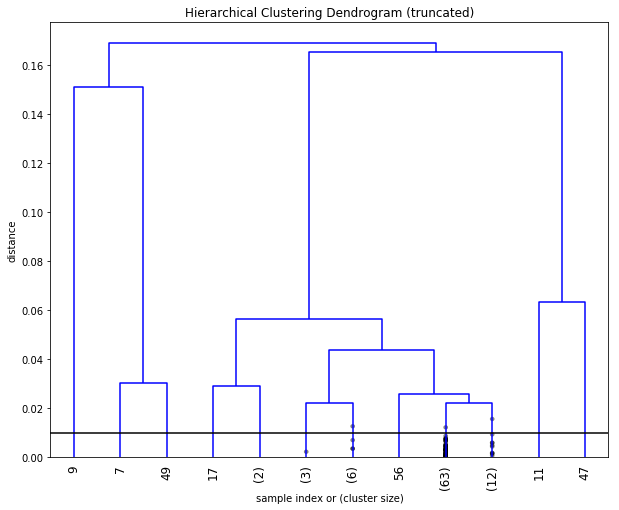

Minkowski


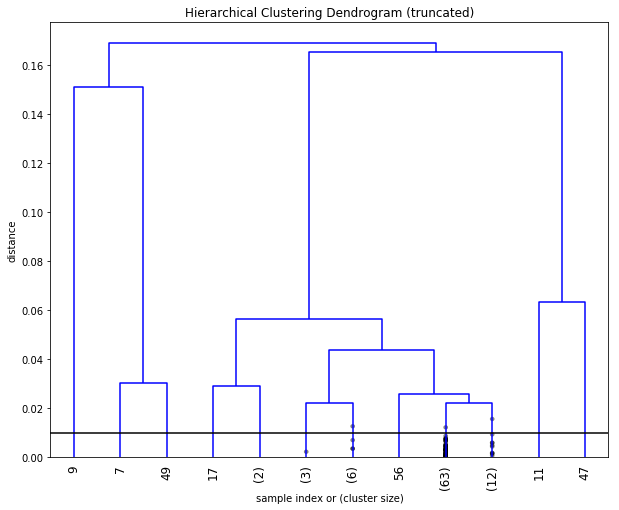

Cityblock


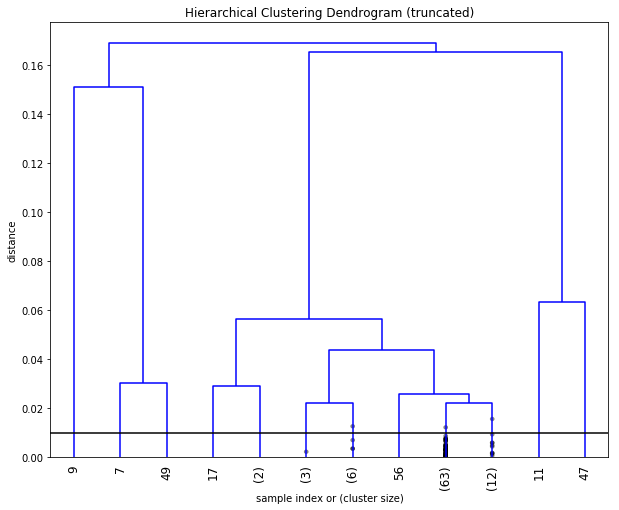

Cosine


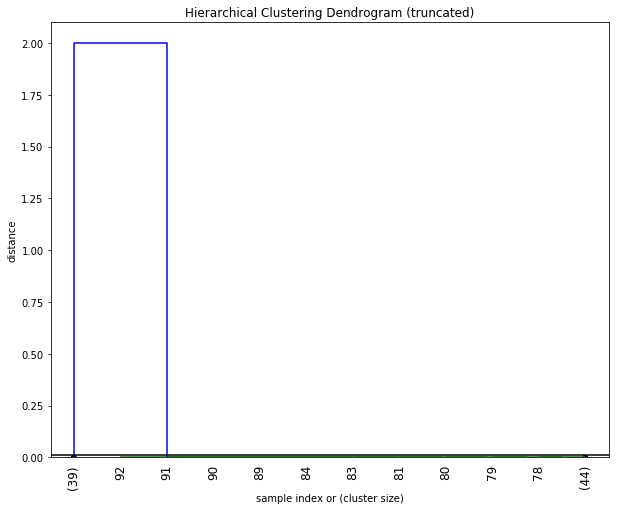

Correlation


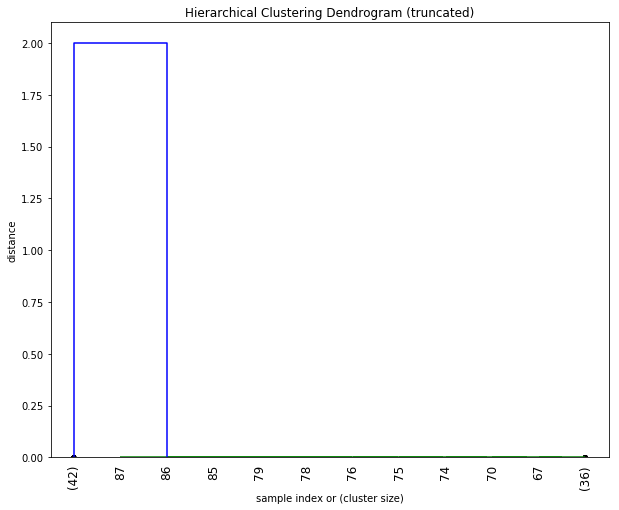

Euclidean Cophenetic Correlation Coefficient: 0.852421694024397
Minkowski Cophenetic Correlation Coefficient: 0.852421694024397
Cityblock Cophenetic Correlation Coefficient: 0.852421694024397
Cosine Cophenetic Correlation Coefficient: 0.3963988115459523
Correlation Cophenetic Correlation Coefficient: 0.2425105432266096
Euclidean Clusters


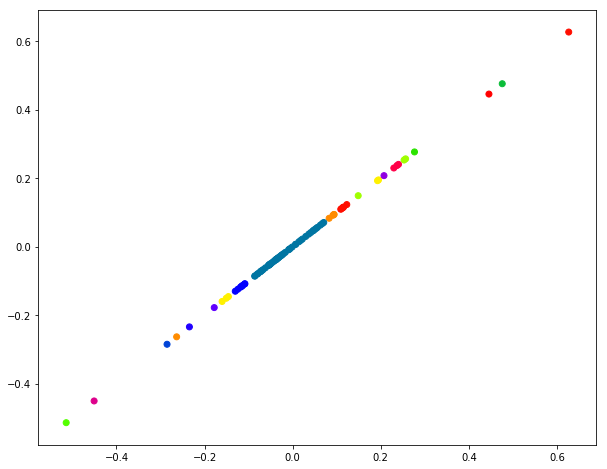

Minkowski Clusters


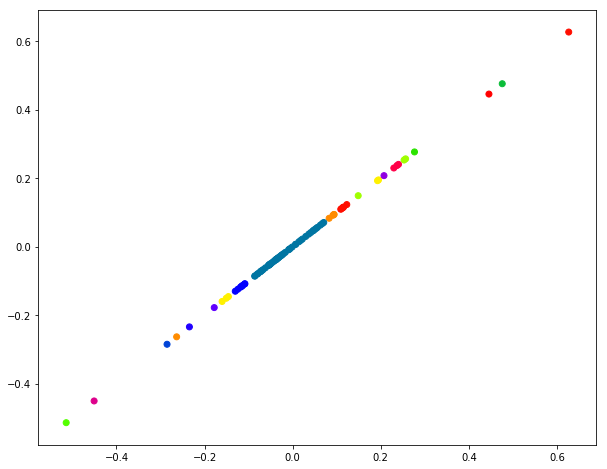

Cityblock Clusters


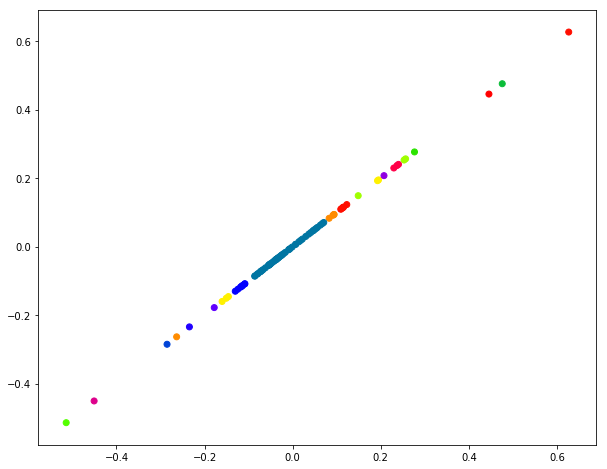

Cosine Clusters


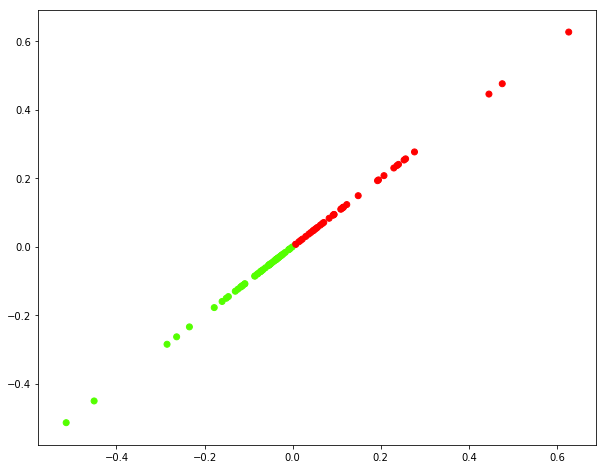

Correlation Clusters


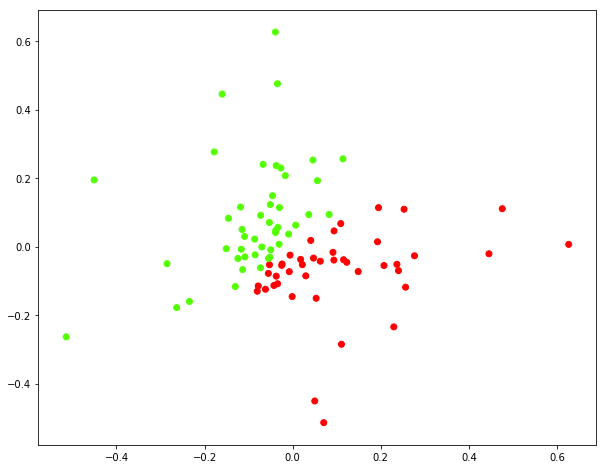

In [12]:
pair = 'BTC_DASH'
timeSeries = pd.DataFrame()
df = get_ohlcv_poloniex(pair=pair, start=1483600958, end=9999999999, period=86400)
df = df[df.index % 7 == 0]
df['pct_change'] = df['weightedAverage'].pct_change()
df['log_ret'] = np.log(df['weightedAverage']) - np.log(df['weightedAverage'].shift(1))
df[pair] = df['log_ret']
df = pd.DataFrame(df[pair])
timeSeries = pd.concat([timeSeries,df], axis=1)
timeSeries = timeSeries.iloc[1:]
print(pair)
generate_clusters(timeSeries, pair)